# Flats in Krakow model training

## Importing Libraries

In [25]:
from datetime import datetime
from distutils.dir_util import copy_tree
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from matplotlib.ticker import MaxNLocator
from pylab import rcParams
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import (GradientBoostingRegressor, RandomForestRegressor,
                              VotingRegressor)
from sklearn.impute import KNNImputer
from sklearn.metrics import (mean_absolute_error, mean_squared_error,
                             mean_squared_log_error)
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

## Setup

In [26]:
# Create directory for images 
Path("img").mkdir(parents=True, exist_ok=True)

# Set default figure size
rcParams['figure.figsize'] = (4, 4)

# Tell pandas how to display floats
pd.options.display.float_format = "{:,.2f}".format

## Load Data

In [27]:
data = pd.read_csv('cleaned_real_estate.csv')

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1767 entries, 0 to 1766
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   District   1767 non-null   object
 1   Amount     1767 non-null   int64 
 2   Seller     1767 non-null   object
 3   Area       1767 non-null   int64 
 4   Rooms      1767 non-null   int64 
 5   Bathrooms  1767 non-null   int64 
 6   Parking    1767 non-null   object
 7   Garden     1767 non-null   bool  
 8   Balcony    1767 non-null   bool  
 9   Terrace    1767 non-null   bool  
 10  Floor      1767 non-null   bool  
 11  New        1767 non-null   bool  
 12  Estate     1767 non-null   bool  
 13  Townhouse  1767 non-null   bool  
 14  Apartment  1767 non-null   bool  
 15  Land       1767 non-null   bool  
 16  Studio     1767 non-null   bool  
dtypes: bool(10), int64(4), object(3)
memory usage: 114.0+ KB


In [29]:
data.head()

,District,Amount,Seller,Area,Rooms,Bathrooms,Parking,Garden,Balcony,Terrace,Floor,New,Estate,Townhouse,Apartment,Land,Studio
0,biezanow,536505,realtor,22,1,1,no parking,False,False,False,False,False,False,False,False,False,False
1,bienczyce,646975,realtor,46,2,1,no parking,True,True,False,False,False,False,True,False,False,False
2,lagiewniki,816233,realtor,37,1,1,no parking,False,False,True,False,True,False,False,False,False,False
3,zwierzyniec,1009826,realtor,55,2,2,no parking,True,False,False,False,True,False,True,False,False,False
4,bronowice,733546,realtor,67,2,1,garage,True,False,False,False,True,False,False,False,False,False


## Feature engineering

The next step is to engineer features. We add columns describing the `Total Rooms` in the property, ratio of `Area to Rooms` and so on.

In [30]:
data['Log Area'] = np.round(np.log(data['Area']), 2)
data['Bool Sum'] = data.select_dtypes(bool).sum(axis=1)
# Avoid division by zero
data['Area to Bool Sum'] = round(data['Area'] / (data.select_dtypes(bool).sum(axis=1) + 1), 2)
data['Rooms to Bool Sum'] = round(data['Rooms'] / (data.select_dtypes(bool).sum(axis=1) + 1), 2)
data['Rooms to Bathrooms' ] = round(data['Rooms'] / data['Bathrooms'], 2)
data['Total Rooms'] = round(data['Rooms'] + data['Bathrooms'], 2)
data['Area to Rooms'] = round(data['Area'] / data['Rooms'], 2)
data['Area to Bathrooms'] = round(data['Area'] / data['Rooms'], 2)
data['Area to Total Rooms'] = round(data['Area'] / data['Total Rooms'], 2)

## Data split

We decide to use $80\%$ of the data to train the model and $20\%$ to check performance.
We make sure to remove the `Amount` column from the training data since this is our target and remove duplicates before training.

In [31]:
print(len(data))
data = data.drop_duplicates()
print(len(data))

1767
1767


In [32]:
X = data.drop(['Amount'], axis=1)
y = data['Amount']

split = train_test_split(X, y, train_size=.8,
                               random_state=123)

X_train, X_test, y_train, y_test = split

## Models

Next step is to create the models and associated piplines. We apply one hot encoding to categorical features and use the `ColumnTransformer` parameter `passthrough` to allow the rest of the columns to remain unchanged.

In [33]:
categorical = list(X.select_dtypes('object').columns)    
continuous = list(X.select_dtypes('int64'))
continuous += list(X.select_dtypes('float64'))

### Baseline model

For comparison purposes we create a model to give base predictions.

In [34]:
dmr = DummyRegressor()

dmr_ohe = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

dmr = Pipeline(steps = [('preprocessor', dmr_ohe),
                        ('regressor', dmr)])

### Multi-layer Perceptron

For the neural network we apply the `MinMaxScaler` so that the continuous columns have values in $[0, 1]$ and then we apply `OneHotEncoder` to the categorical columns.

In [35]:
mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), 
                   max_iter=2*10**4, 
                   random_state=123)

mlp_ohe = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

mlp_scale = Pipeline(
    steps=[('scale', MinMaxScaler())]
)

mlp_pre = ColumnTransformer(
    transformers = [
        ('scale', mlp_scale, continuous),        
        ('cat', mlp_ohe, categorical),
    ],
    remainder='passthrough'
)

mlp_trans = TransformedTargetRegressor(regressor=mlp, 
                                       transformer=MinMaxScaler())

mlp = Pipeline(steps = [('preprocessor', mlp_pre),
                        ('transformer', mlp_trans)])

### Gradient Boosting Regressor
    

For the gradient booster we only apply `OneHotEncoder` to the categorical columns.

In [36]:
gbr = GradientBoostingRegressor(random_state=123)

gbr_ohe = Pipeline(
    steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
)

gbr_pre = ColumnTransformer(
    transformers = [
        ('cat', gbr_ohe, categorical)
    ],
    remainder='passthrough'
)

gbr = Pipeline(steps = [('preprocessor', gbr_pre),
                        ('regressor', gbr)])

## Parameter tuning

We set up the training process to conduct basic parameter tuning and cross validation.

In [37]:
kf = KFold(n_splits=5, random_state=123, shuffle=True)

In [38]:
gbr_grid = {'regressor__max_depth': [5, 10, 15], 
            'regressor__n_estimators': [50, 100, 200, 300],
            'regressor__min_samples_split': [2, 4],
            'regressor__min_samples_leaf': [2, 4],
            'regressor__max_features': ['sqrt', 'log2', 0.8, None]}

gbr_gs = GridSearchCV(estimator=gbr, 
                      param_grid=gbr_grid,
                      cv=kf,
                      n_jobs=8,
                      scoring='neg_root_mean_squared_error',
                      verbose=2)

In [39]:
layers = [(100, 100, 100),
          (150, 200, 150), 
          (200, 400, 200)]

mlp_grid = {'transformer__regressor__activation': ['relu'],
            'transformer__regressor__solver': ['adam'],
            'transformer__regressor__learning_rate': ['adaptive'],
            'transformer__regressor__learning_rate_init': [0.01, 0.001, 0.0001],
            'transformer__regressor__hidden_layer_sizes': layers}

mlp_gs = GridSearchCV(estimator=mlp, 
                      param_grid=mlp_grid,
                      cv=kf,
                      n_jobs=8,
                      scoring='neg_root_mean_squared_error',                      
                      verbose=2)

## Training

In [40]:
dmr.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('onehot',
                                  OneHotEncoder(handle_unknown='ignore'))])),
                ('regressor', DummyRegressor())])

In [41]:
mlp = mlp_gs.fit(X_train, y_train).best_estimator_
mlp

Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Users\Shivansh\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['Area', 'Rooms', 'Bathrooms',
                                                   'Bool Sum', 'Total Rooms',
                                                   'Log Area',
                                                   'Area to Bool Sum',
                                                   'Rooms to Bool Sum',
                                                   'Rooms to Bathrooms',
                                                   'Area to Rooms',
                                                   'Area to Bathrooms',
                                                   'Area to Total Rooms']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['District', 'Seller',
                                                   'Parking'])])),
                ('transformer',
                 TransformedTargetRegressor(regressor=MLPRegressor(hidden_layer_sizes=(150,
                                                                                       200,
                                                                                       150),
                                                                   learning_rate='adaptive',
                                                                   learning_rate_init=0.01,
                                                                   max_iter=20000,
                                                                   random_state=123),
                                            transformer=MinMaxScaler()))])

In [42]:
print(round(abs(mlp_gs.best_score_)))

58574


In [43]:
gbr = gbr_gs.fit(X_train, y_train).best_estimator_
gbr

Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\Users\Shivansh\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['District', 'Seller',
                                                   'Parking'])])),
                ('regressor',
                 GradientBoostingRegressor(max_depth=5, max_features='log2',
                                           min_samples_leaf=4, n_estimators=200,
                                           random_state=123))])

In [44]:
print(round(abs(gbr_gs.best_score_)))

65423


## Voting Regressor

We create a `VotingRegressor` with uniform weights to be able to combine predictions of our models.

In [45]:
vote = VotingRegressor(estimators=[['mlp', mlp], ['gbr', gbr]], n_jobs=8)
vote = vote.fit(X_train, y_train)

## Model performance

We obtain predictions for the testing set and compare `RMSE`, `MAE` and `MSLE` scores of our models.

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error

def get_scores(regressor, X_test, y_true, verb=True):
    """
    Obtain RMSE, MAE, and MSLE for test set.
    """
    y_pred = regressor.predict(X_test)

    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5  # Manually calculate RMSE
    mae  = mean_absolute_error(y_true, y_pred)
    msle = mean_squared_log_error(y_true, y_pred)

    if verb:
        print(f'RMSE: {rmse:10.2f}')
        print(f'MAE:  {mae:10.2f}')
        print(f'MSLE: {msle:10.2f}')        

    return (rmse, mae, msle)


### Dummy

In [56]:
dmr_score = get_scores(regressor=dmr, 
                       X_test=X_test, 
                       y_true=y_test)mlp_score = get_scores(regressor=mlp, 
                       X_test=X_test, 
                       y_true=y_test)

RMSE:  168126.84
MAE:   138843.39
MSLE:       0.05


### Multilayer Perceptrion

In [57]:
mlp_score = get_scores(regressor=mlp, 
                       X_test=X_test, 
                       y_true=y_test)

RMSE:   57347.10
MAE:    44959.86
MSLE:       0.01


### Gradient Boosting Regressor

In [58]:
gbr_score = get_scores(regressor=gbr, 
                       X_test=X_test, 
                       y_true=y_test)

RMSE:   61427.51
MAE:    48322.82
MSLE:       0.01


### Voting Regressor

In [59]:
vote_score = get_scores(regressor=vote, 
                        X_test=X_test, 
                        y_true=y_test)

RMSE:   55847.01
MAE:    43451.06
MSLE:       0.01


### Comparison

We are happy to see that the `VotingRegressor` outperforms the `DummyRegressor` model as well the `GradientBoostingRegressor` and the `MLPRegressor`.

In [60]:
scores = [dmr_score,
          mlp_score,
          gbr_score,
          vote_score]

scores = pd.DataFrame(scores, 
                      index=['DMR', 'MLP', 'GBR', 'VOTE'], 
                      columns=['RMSE', 'MAE', 'MSLE'])

scores

,RMSE,MAE,MSLE
DMR,"168,126.84","138,843.39",0.05
MLP,"57,347.10","44,959.86",0.01
GBR,"61,427.51","48,322.82",0.01
VOTE,"55,847.01","43,451.06",0.01


## Visualizations 

We produce a couple of plots the visually inspect the performance of our model. We use the test data set with the predicted Amount to produce the plots.

In [61]:
cols = ['Amount', 'Predicted Amount', 
        'District', 'Area', 'Total Rooms']

X_pred = X_test.copy()
X_pred.loc[:, 'Amount'] = y
X_pred.loc[:, 'Predicted Amount'] = vote.predict(X_test)
X_pred = X_pred.loc[:, cols]

X_pred.head()

,Amount,Predicted Amount,District,Area,Total Rooms
318,916413,"918,278.87",prokocim,133,5
1697,748405,"766,078.58",pradnik bialy,82,6
929,696993,"687,888.77",pradnik bialy,59,3
1614,1104201,"1,035,476.11",pradnik bialy,110,6
813,1052020,"932,207.31",podgorze,36,2


On our first visual it can be seen that there exists a somewhat linear relationship between the `Predicted Amount` and the `Area` of the property.

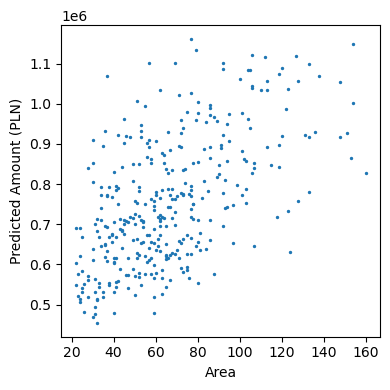

In [62]:
plt.scatter(X_pred['Area'], X_pred['Predicted Amount'], s=2)
plt.xlabel('Area')
plt.ylabel('Predicted Amount (PLN)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('img/area_vs_amount.png')
plt.show()

On the second visual it can bee seen, as expected the more `Total Rooms` in a `Property` the more it should cost.

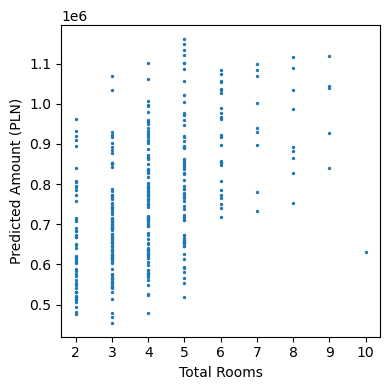

In [63]:
plt.scatter(X_pred['Total Rooms'], X_pred['Predicted Amount'], s=2)
plt.xlabel('Total Rooms')
plt.ylabel('Predicted Amount (PLN)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.savefig('img/rooms_vs_amount.png')
plt.show()

Next we want to check if the model distinguishes between districts. We group the data by `District` and calculate the mean of the predictions with the group. We produce a bar chart sorted from highest average to lowest. Clearly the model distinguishes between district that are near the city center (`stare miasto`, `zwierzyniec`) and those further away (`łag`, `bieżanów`).

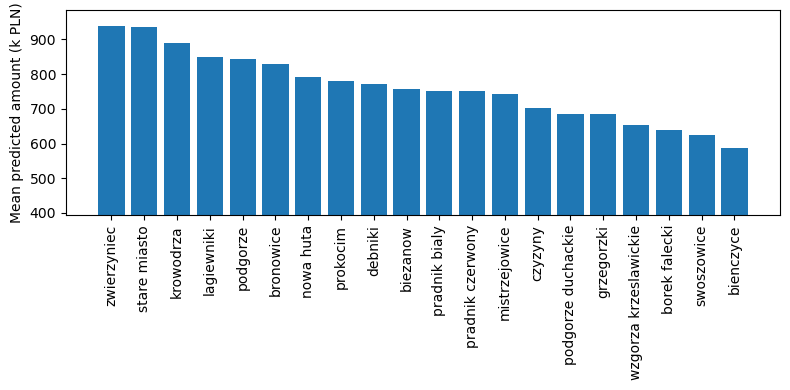

In [64]:
width = 1600
height = width/2
dpi = 200

X_grp = X_pred[['District', 'Predicted Amount']]
X_grp = X_grp.groupby('District', as_index=False).mean()
X_grp = X_grp.sort_values('Predicted Amount', ascending=False)

plt.figure(figsize=(width/dpi, height/dpi))

plt.bar(X_grp['District'], X_grp['Predicted Amount'] / 1000)

plt.ylabel('Mean predicted amount (k PLN)')
plt.ylim(X_grp['Predicted Amount'].min() * 0.67 / 1000, None)
plt.xticks(rotation=90)

plt.tight_layout()
plt.savefig('img/district_vs_avg_amount.png')
plt.show()

## Getting predictions

Next we would like see how the model handles sets of arbitrary parameters. We write a function to transform inputs to desired format and obtain prediction from the model.

In [72]:
def get_pred(
    district, seller, area, rooms, bathrooms,
    parking, garden, balcony, terrace, floor,
    new, estate, townhouse, apartment, land, studio
):
    """
    Generate a price prediction using engineered features matching training.
    """
    try:
        # Raw features
        x = pd.DataFrame([{
            'District': district,
            'Seller': seller,
            'Area': area,
            'Rooms': rooms,
            'Bathrooms': bathrooms,
            'Parking': parking,
            'Garden': garden,
            'Balcony': balcony,
            'Terrace': terrace,
            'Floor': floor,
            'New': new,
            'Estate': estate,
            'Townhouse': townhouse,
            'Apartment': apartment,
            'Land': land,
            'Studio': studio
        }])

        # Feature engineering (must match training logic exactly)
        x['Total Rooms'] = x['Rooms'] + x['Bathrooms']
        x['Bool Sum'] = x[['Garden', 'Balcony', 'Terrace', 'Floor', 'New',
                           'Estate', 'Townhouse', 'Apartment', 'Land', 'Studio']].sum(axis=1)
        x['Rooms to Bathrooms'] = x['Rooms'] / x['Bathrooms']
        x['Area to Rooms'] = x['Area'] / x['Rooms']
        x['Area to Bathrooms'] = x['Area'] / x['Bathrooms']
        x['Area to Total Rooms'] = x['Area'] / x['Total Rooms']
        x['Rooms to Bool Sum'] = x['Rooms'] / (x['Bool Sum'] + 1)
        x['Area to Bool Sum'] = x['Area'] / (x['Bool Sum'] + 1)
        x['Log Area'] = np.log1p(x['Area'])

        # Match column order if needed (optional, only if trained model is strict)

        # Predict using model
        pred = vote.predict(x)[0]
        return float(pred)

    except Exception as e:
        print(f"Error predicting for district={district}, area={area}: {e}")
        return None


We create lists of inputs for the model to predict.

In [73]:
areas = range(30, 120, 5)
rooms = range(1, 5)
districts = ['stare miasto', 
             'bronowice', 
             'krowodrza',
             'borek falecki']

Next we loop over lists of possible `Area`'s and `Room`'s and plot the outputs. First we check how the model reacts to different districts.

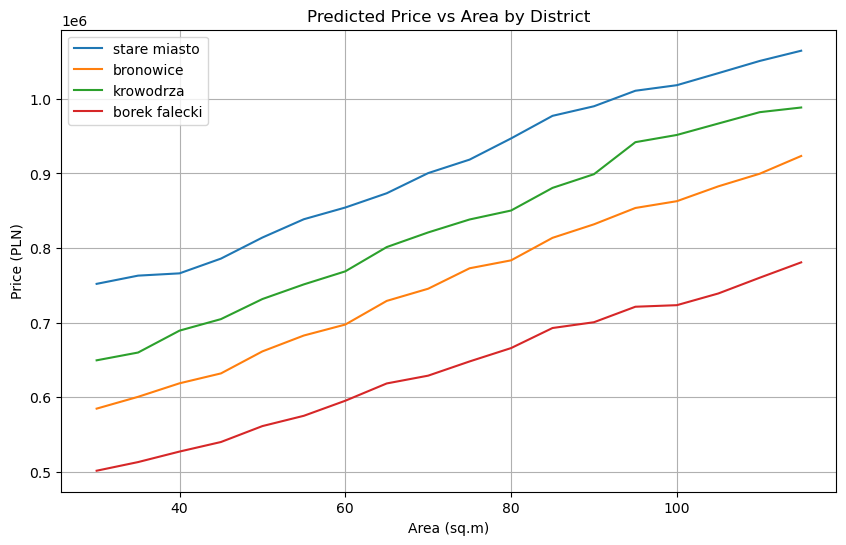

In [74]:
plt.figure(figsize=(10, 6))  # Optional: improve size

for d in districts:
    values = []
    for a in areas:
        try:
            pred = get_pred(
                district=d,
                seller='realtor',
                area=a,
                rooms=2,
                bathrooms=1,
                parking='street',
                garden=False,
                balcony=False,
                terrace=False,
                floor=False,
                new=True,
                estate=False,
                townhouse=True,
                apartment=False,
                land=False,
                studio=True
            )
            # Assuming pred is scalar
            values.append(pred if isinstance(pred, (int, float)) else float(pred[0]))
        except Exception as e:
            print(f"Error predicting for district={d}, area={a}: {e}")
            values.append(None)

    plt.plot(areas, values, label=d)

plt.ylabel('Price (PLN)')
plt.xlabel('Area (sq.m)')
plt.title('Predicted Price vs Area by District')
plt.grid(True)
plt.legend(loc='best')

# Save as .png for clarity
plt.savefig('img/area_vs_amount_by_district.png', dpi=300, bbox_inches='tight')
plt.show()

We do the same for different amounts of `Room`'s.

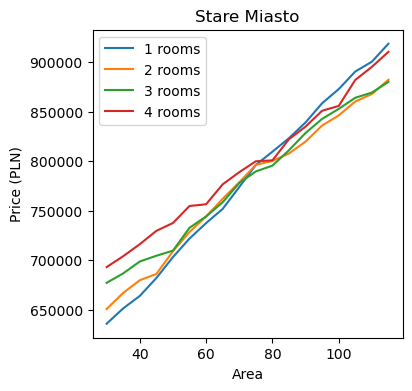

In [75]:
plt.figure()

for r in rooms:
    value = list()
    for a in areas:
        pred = get_pred(district='stare miasto',
         seller='owner',
         area=a,
         rooms=r,
         bathrooms=1,
         parking='street',
         garden=False,
         balcony=True,
         terrace=False,
         floor=False,
         new=True,
         estate=False,
         townhouse=True,
         apartment=False,
         land=False,
         studio=True)
        value.append(pred)
    plt.plot(areas, value, label=f'{r} rooms')
    
plt.title('Stare Miasto')
plt.ylabel('Price (PLN)')
plt.xlabel('Area')    
plt.legend(loc='best')
plt.savefig('img/area_vs_amount_by_rooms')
plt.show()

## Final training

The last step is to fit the model to the entire dataset and save it for later use.

In [1]:
import os

save_dir = os.path.expanduser('~/Desktop/flats in krakow/ml-anal')
os.makedirs(save_dir, exist_ok=True) 



In [82]:
from datetime import datetime
import joblib

start = datetime.now()

# Save models
gbr.fit(X, y)
joblib.dump(gbr, os.path.join(save_dir, 'gbr.joblib'))

joblib.dump(mlp, os.path.join(save_dir, 'mlp.joblib'))
joblib.dump(vote, os.path.join(save_dir, 'vote.joblib'))

end = datetime.now()

duration = (end - start).seconds
print(f'Full training took {duration} seconds.')


Full training took 0 seconds.
